# Exploratory Data Analysis: Netflix Dataset



## 1. Data Import & Initial Assessment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load dataset
df = pd.read_csv('/content/netflix_titles.csv')

print(f"Dataset loaded: {df.shape[0]:,} observations × {df.shape[1]} features")
print(f"Memory footprint: {df.memory_usage(deep=True).sum()/1024**2:.1f} MB")

Dataset loaded: 8,807 observations × 12 features
Memory footprint: 8.5 MB


In [3]:
# Dataset overview
print("Dataset Structure:")
df.info()

print("\nSample Records:")
display(df.head())

print("\nData Types Summary:")
print(df.dtypes.value_counts().to_dict())

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Sample Records:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...



Data Types Summary:
{dtype('O'): 11, dtype('int64'): 1}


## 2. Data Quality Assessment

Data Quality Issues:


,Missing_Count,Missing_Percentage,Data_Type
director,2634,29.91,object
country,831,9.44,object
cast,825,9.37,object
date_added,10,0.11,object
rating,4,0.05,object
duration,3,0.03,object


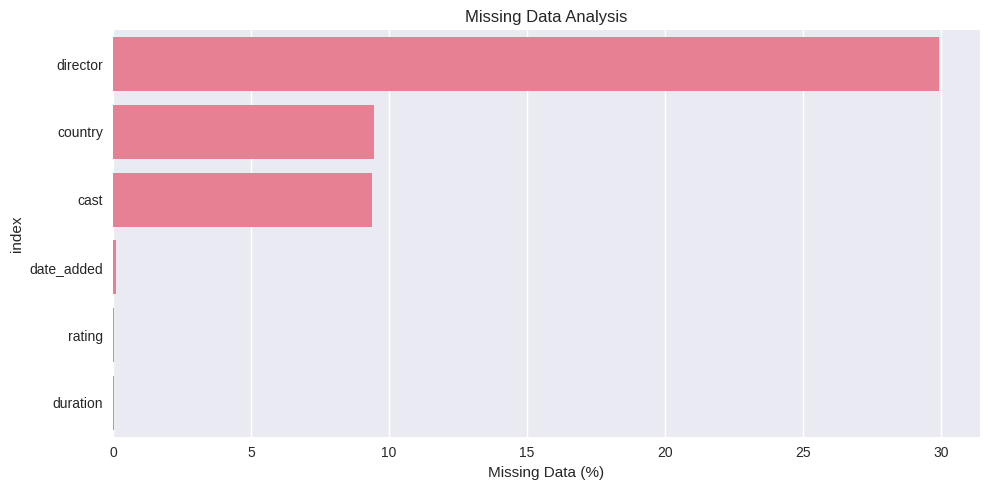

In [4]:
# Missing data analysis
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df) * 100).round(2)

quality_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct,
    'Data_Type': df.dtypes
})

# Filter and display problematic columns
issues = quality_summary[quality_summary['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(issues) > 0:
    print("Data Quality Issues:")
    display(issues)

    # Visualization for missing data
    if len(issues) <= 10:
        plt.figure(figsize=(10, 5))
        sns.barplot(data=issues.reset_index(), y='index', x='Missing_Percentage', orient='h')
        plt.title('Missing Data Analysis')
        plt.xlabel('Missing Data (%)')
        plt.tight_layout()
        plt.show()
else:
    print(" Data quality check passed - no missing values detected")

In [6]:
df[['director', 'country', 'cast']] = df[['director', 'country', 'cast']].fillna('Unknown')

In [7]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['release_year'] = pd.to_datetime(df['release_year'], format='%Y', errors='coerce')

# Function to convert duration strings to integer minutes or seasons
def convert_duration(duration):
    if isinstance(duration, str):
        parts = duration.split()
        if len(parts) == 2:
            try:
                return int(parts[0])
            except ValueError:
                return np.nan
    return np.nan # Handle cases that are not strings or don't fit the format

df['duration_int'] = df['duration'].apply(convert_duration)

print("\nUpdated Data Types Summary:")
print(df.dtypes.value_counts().to_dict())


Updated Data Types Summary:
{dtype('O'): 10, dtype('<M8[ns]'): 2, dtype('float64'): 1}


In [8]:
# Mapping of ratings to numerical scale (example: G=0, PG=1, PG-13=2, etc.)
rating_map = {
    'G': 0,
    'PG': 1,
    'PG-13': 2,
    'TV-G': 3,
    'TV-PG': 4,
    'TV-Y': 5,
    'TV-Y7': 6,
    'TV-Y7-FV': 7,
    'R': 8,
    'NC-17': 9,
    'TV-MA': 10,
    'UR': np.nan, # Assuming 'UR' (Unrated) can be treated as missing or unknown
    'NR': np.nan  # Assuming 'NR' (Not Rated) can be treated as missing or unknown
}

df['rating_numeric'] = df['rating'].map(rating_map)

print("\nUpdated Data Types Summary after converting rating:")
print(df.dtypes.value_counts().to_dict())

# Display the first few rows with the new numeric rating column
print("\nSample Records with Numeric Rating:")
display(df[['rating', 'rating_numeric']].head())

# Check unique values and how they were mapped (useful for verification)
print("\nUnique Ratings and their Numeric Mapping:")
print(df[['rating', 'rating_numeric']].drop_duplicates().sort_values('rating_numeric'))



Updated Data Types Summary after converting rating:
{dtype('O'): 10, dtype('<M8[ns]'): 2, dtype('float64'): 2}

Sample Records with Numeric Rating:


,rating,rating_numeric
0,PG-13,2.0
1,TV-MA,10.0
2,TV-MA,10.0
3,TV-MA,10.0
4,TV-MA,10.0



Unique Ratings and their Numeric Mapping:
        rating  rating_numeric
107          G             0.0
6           PG             1.0
0        PG-13             2.0
66        TV-G             3.0
13       TV-PG             4.0
23        TV-Y             5.0
34       TV-Y7             6.0
6581  TV-Y7-FV             7.0
46           R             8.0
5264     NC-17             9.0
1        TV-MA            10.0
8        TV-14             NaN
5541    74 min             NaN
5794    84 min             NaN
5813    66 min             NaN
5971        NR             NaN
5989       NaN             NaN
7058        UR             NaN


In [9]:


# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

if duplicates > 0:
    print("Handling duplicate rows: Dropping duplicates.")
    df.drop_duplicates(inplace=True)
    print(f"Dataset shape after removing duplicates: {df.shape[0]:,} observations × {df.shape[1]} features")
else:
    print("No duplicate rows found.")


Number of duplicate rows: 0
No duplicate rows found.


In [10]:
df['duration_unit'] = df['duration'].apply(lambda x: x.split()[-1] if isinstance(x, str) and ' ' in x else None)

print("\nUpdated Data Types Summary after processing duration:")
print(df.dtypes.value_counts().to_dict())

print("\nSample Records with Duration Unit:")
display(df[['duration', 'duration_int', 'duration_unit']].head())

print("\nValue counts for Duration Unit:")
print(df['duration_unit'].value_counts(dropna=False))


Updated Data Types Summary after processing duration:
{dtype('O'): 11, dtype('<M8[ns]'): 2, dtype('float64'): 2}

Sample Records with Duration Unit:


,duration,duration_int,duration_unit
0,90 min,90.0,min
1,2 Seasons,2.0,Seasons
2,1 Season,1.0,Season
3,1 Season,1.0,Season
4,2 Seasons,2.0,Seasons



Value counts for Duration Unit:
duration_unit
min        6128
Season     1793
Seasons     883
None          3
Name: count, dtype: int64


In [11]:
#final dataset information after cleaning

print("\nFinal Dataset Information after cleaning:")
print(f"Dataset shape: {df.shape[0]:,} observations × {df.shape[1]} features")
print(f"Memory footprint: {df.memory_usage(deep=True).sum()/1024**2:.1f} MB")
df.info()
print("\nData Types Summary:")
print(df.dtypes.value_counts().to_dict())
print("\nSample Records:")
display(df.head())


Final Dataset Information after cleaning:
Dataset shape: 8,807 observations × 15 features
Memory footprint: 9.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   show_id         8807 non-null   object        
 1   type            8807 non-null   object        
 2   title           8807 non-null   object        
 3   director        8807 non-null   object        
 4   cast            8807 non-null   object        
 5   country         8807 non-null   object        
 6   date_added      8709 non-null   datetime64[ns]
 7   release_year    8807 non-null   datetime64[ns]
 8   rating          8803 non-null   object        
 9   duration        8804 non-null   object        
 10  listed_in       8807 non-null   object        
 11  description     8807 non-null   object        
 12  duration_int    8804 non-null   float64     

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_int,rating_numeric,duration_unit
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020-01-01,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90.0,2.0,min
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021-01-01,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2.0,10.0,Seasons
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021-01-01,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1.0,10.0,Season
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021-01-01,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",1.0,10.0,Season
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021-01-01,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2.0,10.0,Seasons


## 3. Variable Classification & Summary Statistics

In [12]:
# Classify variables by type
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

print(f"Variable Classification:")
print(f"• Numeric: {len(numeric_cols)} variables")
print(f"• Categorical: {len(categorical_cols)} variables")
print(f"• DateTime: {len(datetime_cols)} variables")

# Summary statistics for numeric variables
if numeric_cols:
    print("\nDescriptive Statistics (Numeric Variables):")
    display(df[numeric_cols].describe().round(2))

Variable Classification:
• Numeric: 2 variables
• Categorical: 11 variables
• DateTime: 2 variables

Descriptive Statistics (Numeric Variables):


,duration_int,rating_numeric
count,8804.00,6557.00
mean,69.85,7.24
std,50.81,3.19
min,1.00,0.00
25%,2.00,4.00
50%,88.00,8.00
75%,106.00,10.00
max,312.00,10.00


## 4. Univariate Analysis

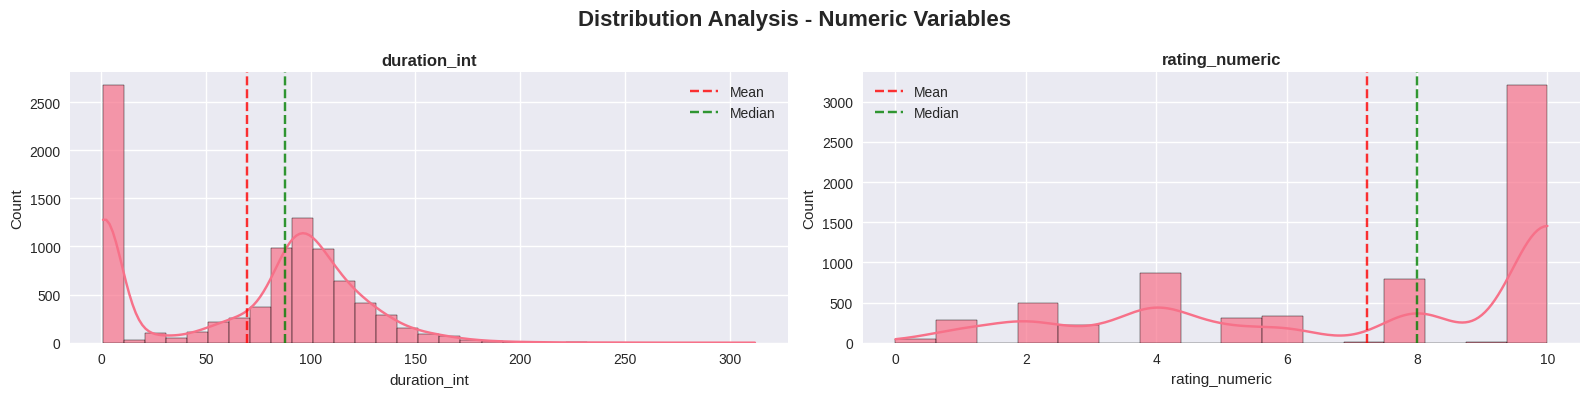

In [15]:
# Numeric variable distributions
if numeric_cols:
    n_cols = min(4, len(numeric_cols))
    n_rows = (len(numeric_cols[:8]) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    if len(numeric_cols) == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols[:8]):
        sns.histplot(df[col], kde=True, ax=axes[i], alpha=0.7)
        axes[i].axvline(df[col].mean(), color='red', linestyle='--', alpha=0.8, label='Mean')
        axes[i].axvline(df[col].median(), color='green', linestyle='--', alpha=0.8, label='Median')
        axes[i].set_title(f'{col}', fontweight='bold')
        axes[i].legend()

    # Hide unused subplots
    for i in range(len(numeric_cols[:8]), len(axes)):
        axes[i].axis('off')

    plt.suptitle('Distribution Analysis - Numeric Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


Value Counts (Categorical Variables):

--- show_id ---
show_id
s8807    1
s1       1
s2       1
s3       1
s4       1
s5       1
s6       1
s8791    1
s8790    1
s8789    1
Name: count, dtype: int64

--- type ---
type
Movie      6131
TV Show    2676
Name: count, dtype: int64

--- title ---
title
Zubaan                           1
Dick Johnson Is Dead             1
Blood & Water                    1
Ganglands                        1
Jailbirds New Orleans            1
Kota Factory                     1
Midnight Mass                    1
You Don't Mess with the Zohan    1
You Changed My Life              1
You Carry Me                     1
Name: count, dtype: int64

--- director ---
director
Unknown                   2634
Rajiv Chilaka               19
Raúl Campos, Jan Suter      18
Suhas Kadav                 16
Marcus Raboy                16
Jay Karas                   14
Cathy Garcia-Molina         13
Martin Scorsese             12
Youssef Chahine             12
Jay Chapman         

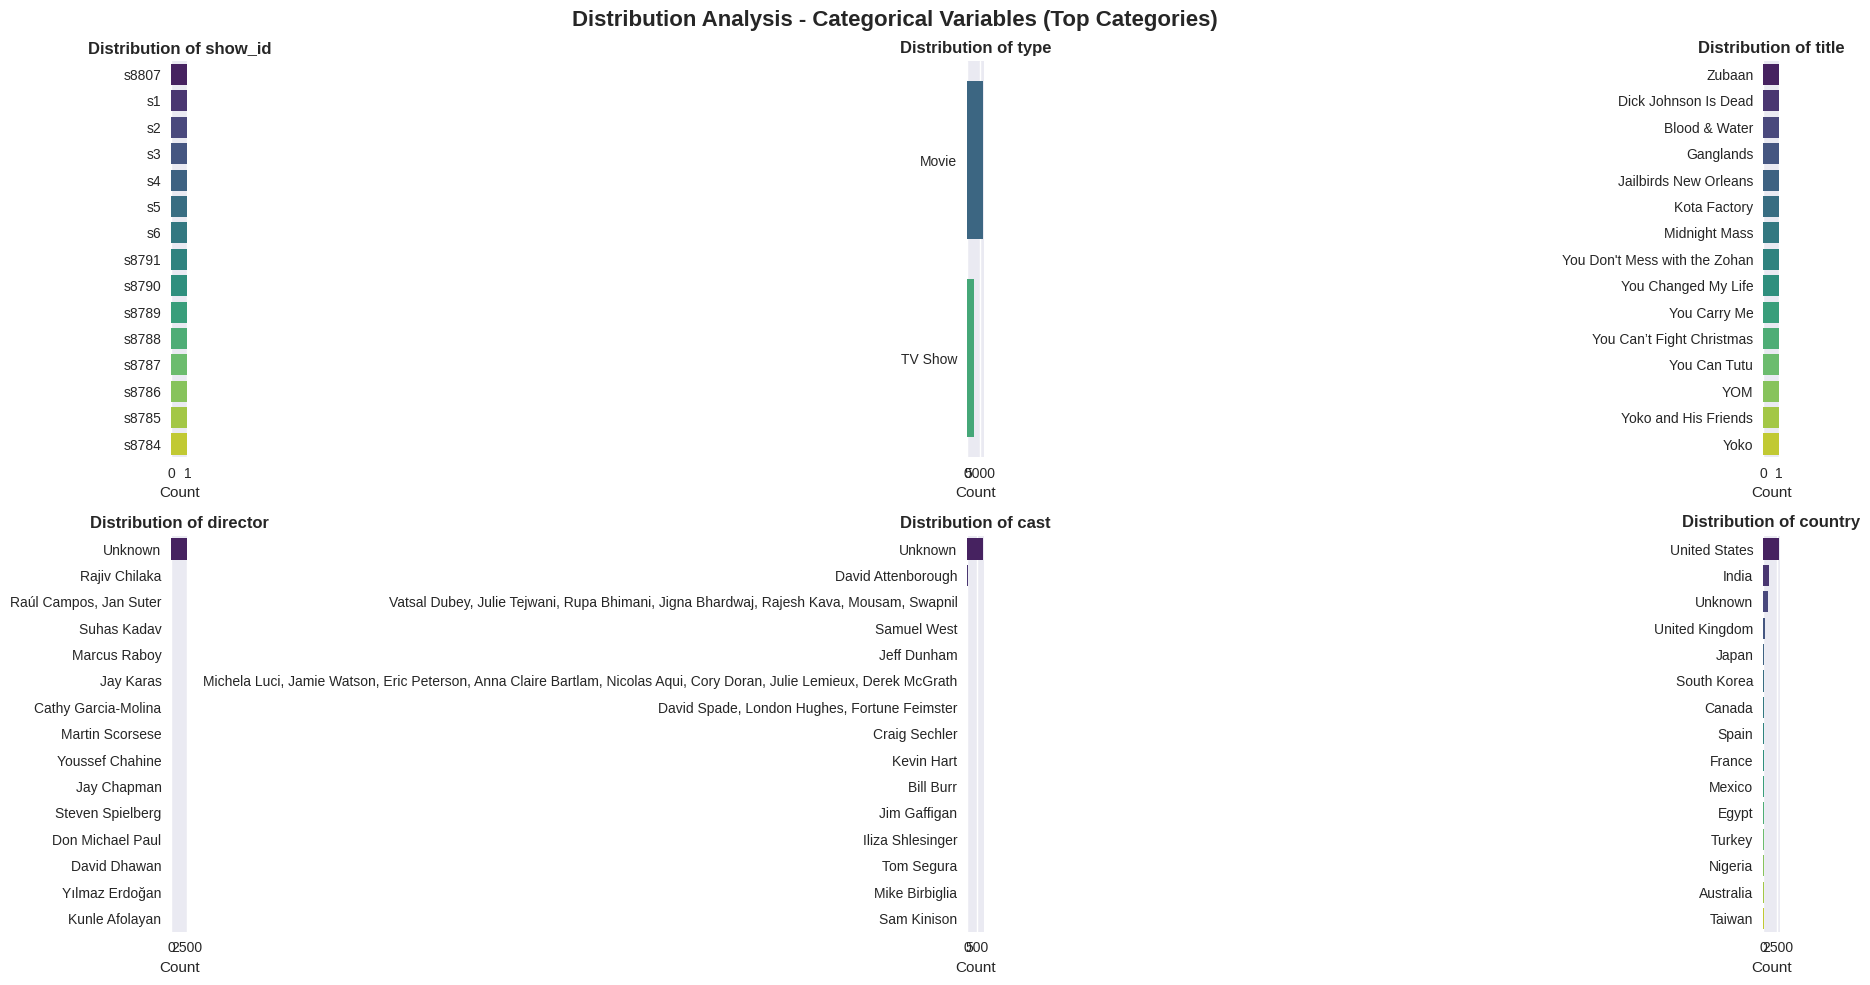

In [18]:


# Categorical variable distributions
if categorical_cols:
    print("\nValue Counts (Categorical Variables):")
    for col in categorical_cols[:5]: # Limiting to first 5 for brevity
        print(f"\n--- {col} ---")
        print(df[col].value_counts().head(10)) # Display top 10 values

    # Visualize categorical distributions (top N categories)
    n_cols = min(3, len(categorical_cols))
    n_rows = (len(categorical_cols[:6]) + n_cols - 1) // n_cols

    if n_rows > 0:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
        if len(categorical_cols[:6]) == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()

        for i, col in enumerate(categorical_cols[:6]):
            # Get value counts and select top N (e.g., top 15)
            top_n = df[col].value_counts().nlargest(15).index
            data_to_plot = df[df[col].isin(top_n)]

            sns.countplot(data=data_to_plot, y=col, order=top_n, ax=axes[i], palette='viridis')
            axes[i].set_title(f'Distribution of {col}', fontweight='bold')
            axes[i].set_xlabel('Count')
            axes[i].set_ylabel('') # Remove y-label as the column name is the title

        # Hide unused subplots
        for i in range(len(categorical_cols[:6]), len(axes)):
            axes[i].axis('off')

        plt.suptitle('Distribution Analysis - Categorical Variables (Top Categories)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()





Time-Series Analysis (DateTime Variables):


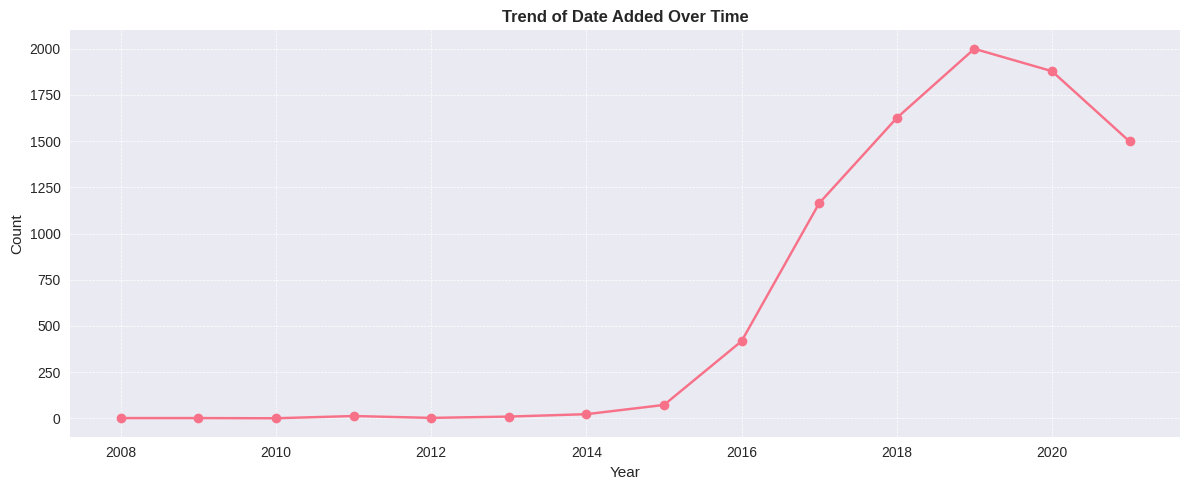

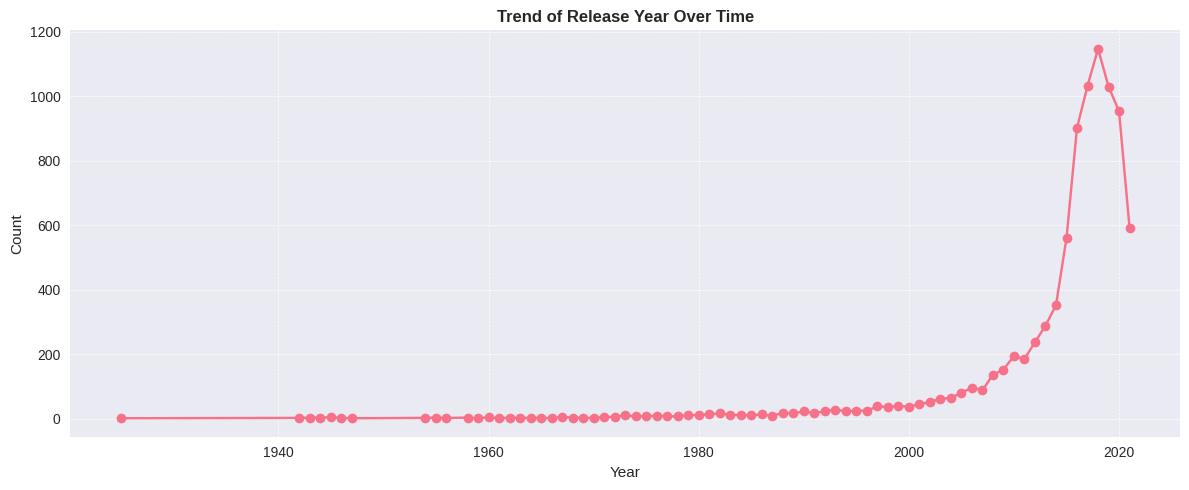

In [19]:

# Datetime variable analysis
if datetime_cols:
    print("\nTime-Series Analysis (DateTime Variables):")
    for col in datetime_cols:
        if not df[col].isnull().all(): # Only plot if there are valid datetime values
            plt.figure(figsize=(12, 5))
            df[col].dt.year.value_counts().sort_index().plot(kind='line', marker='o')
            plt.title(f'Trend of {col.replace("_", " ").title()} Over Time', fontweight='bold')
            plt.xlabel('Year')
            plt.ylabel('Count')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print(f"'{col}' contains only missing values, skipping time-series plot.")

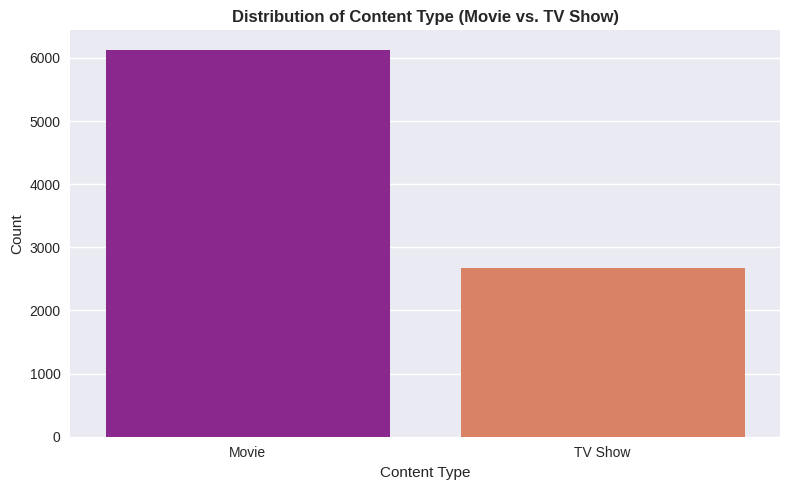

In [20]:
# Analyze 'type' variable specifically as it's key
if 'type' in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='type', palette='plasma')
    plt.title('Distribution of Content Type (Movie vs. TV Show)', fontweight='bold')
    plt.xlabel('Content Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## 5. Multivariate Analysis


Correlation Matrix (Numeric Variables):


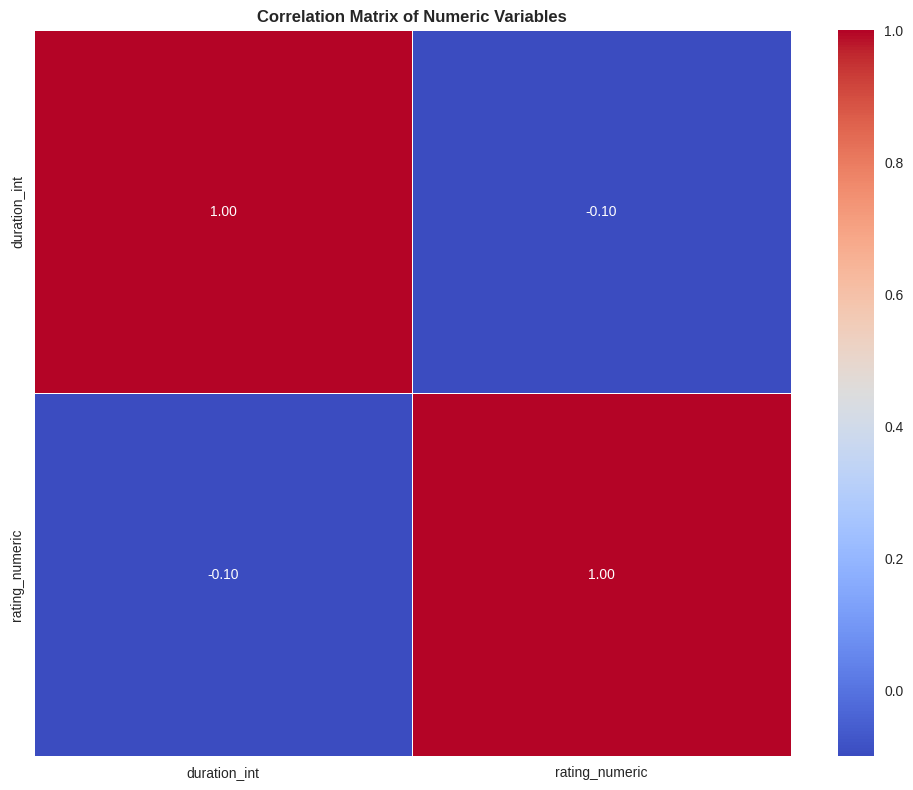

In [30]:

# Relationships between numerical variables (e.g., correlation matrix)
if numeric_cols:
    print("\nCorrelation Matrix (Numeric Variables):")
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numeric Variables', fontweight='bold')
    plt.tight_layout()
    plt.show()


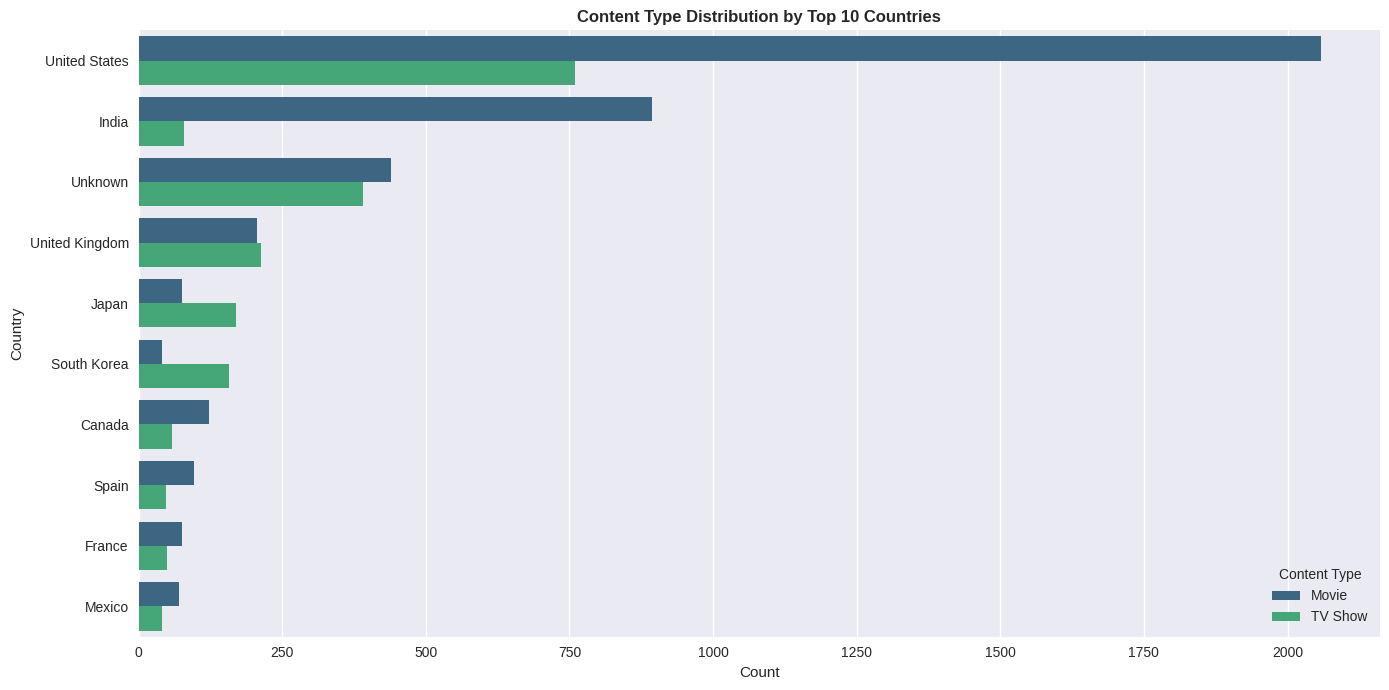

In [31]:
# Analyzing relationships involving 'country' (top N countries)
if 'country' in categorical_cols and 'type' in categorical_cols:
    # Get top N countries (e.g., top 10)
    top_countries = df['country'].value_counts().nlargest(10).index
    df_top_countries = df[df['country'].isin(top_countries)]

    if not df_top_countries.empty:
        plt.figure(figsize=(14, 7))
        sns.countplot(data=df_top_countries, y='country', hue='type', order=top_countries, palette='viridis')
        plt.title('Content Type Distribution by Top 10 Countries', fontweight='bold')
        plt.xlabel('Count')
        plt.ylabel('Country')
        plt.legend(title='Content Type')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data to plot content type distribution by top countries.")

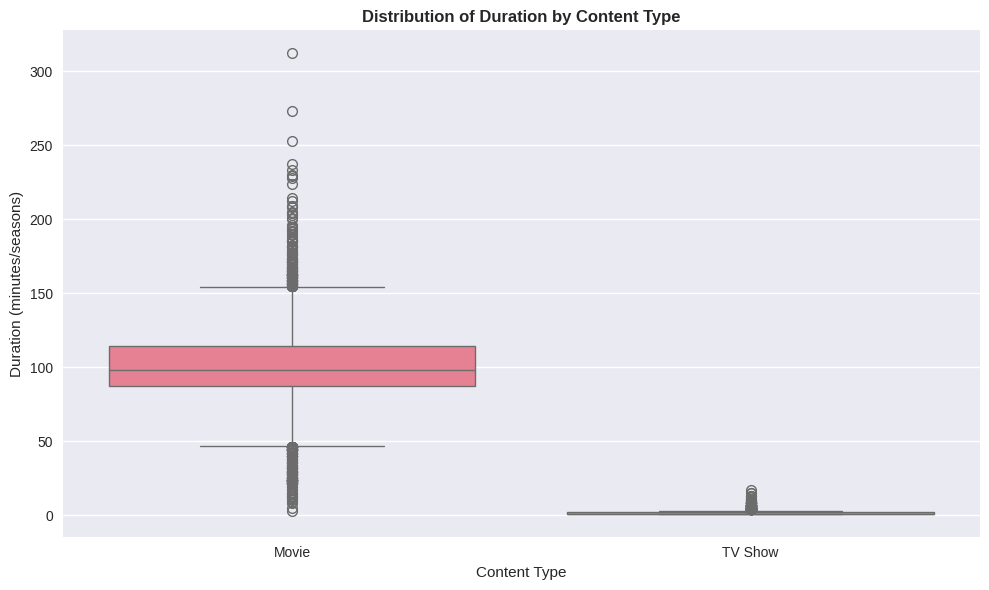

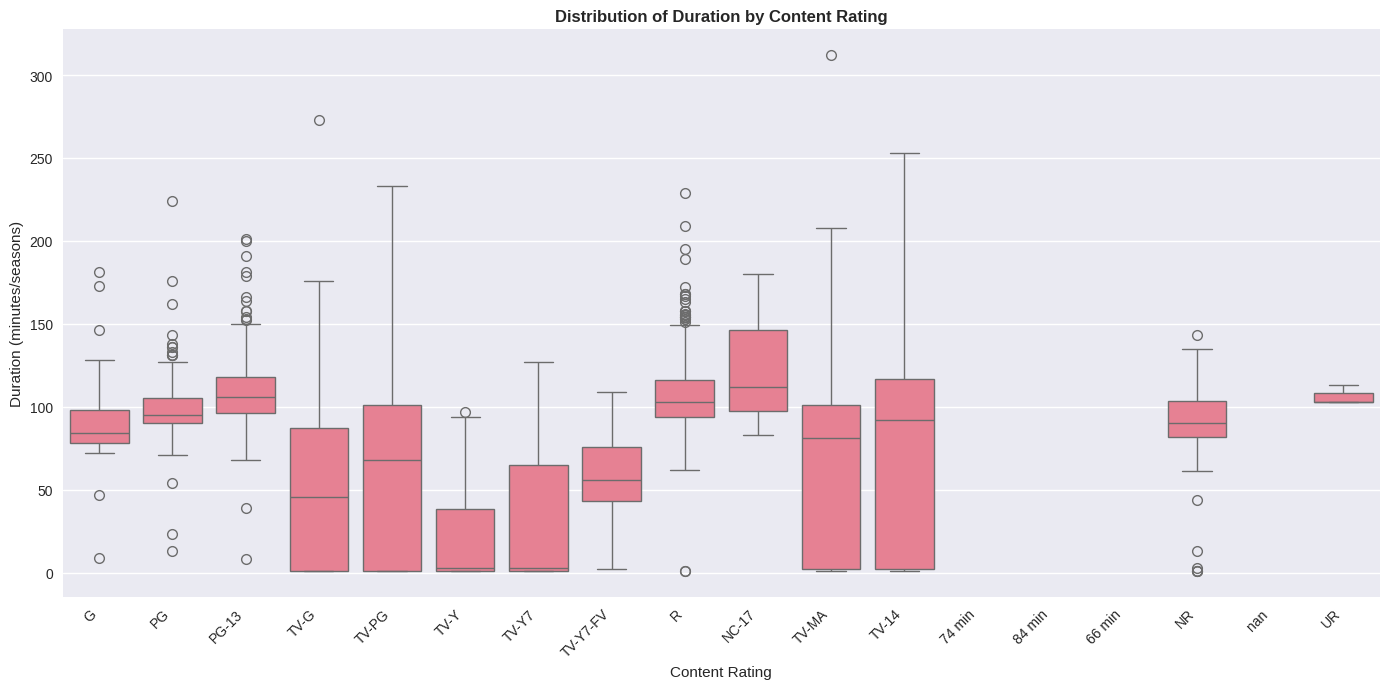

In [25]:
# Relationships between categorical and numerical variables (e.g., box plots or violin plots)
if 'type' in categorical_cols and 'duration_int' in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='type', y='duration_int')
    plt.title('Distribution of Duration by Content Type', fontweight='bold')
    plt.xlabel('Content Type')
    plt.ylabel('Duration (minutes/seasons)')
    plt.tight_layout()
    plt.show()

if 'rating' in categorical_cols and 'duration_int' in numeric_cols:
    # Use rating_numeric for better ordering on the plot
    if 'rating_numeric' in numeric_cols:
         # Sort ratings by their numeric value for better visualization order
        sorted_ratings = df.sort_values('rating_numeric')['rating'].unique()

        plt.figure(figsize=(14, 7))
        sns.boxplot(data=df, x='rating', y='duration_int', order=sorted_ratings)
        plt.title('Distribution of Duration by Content Rating', fontweight='bold')
        plt.xlabel('Content Rating')
        plt.ylabel('Duration (minutes/seasons)')
        plt.xticks(rotation=45, ha='right') # Rotate labels for readability
        plt.tight_layout()
        plt.show()

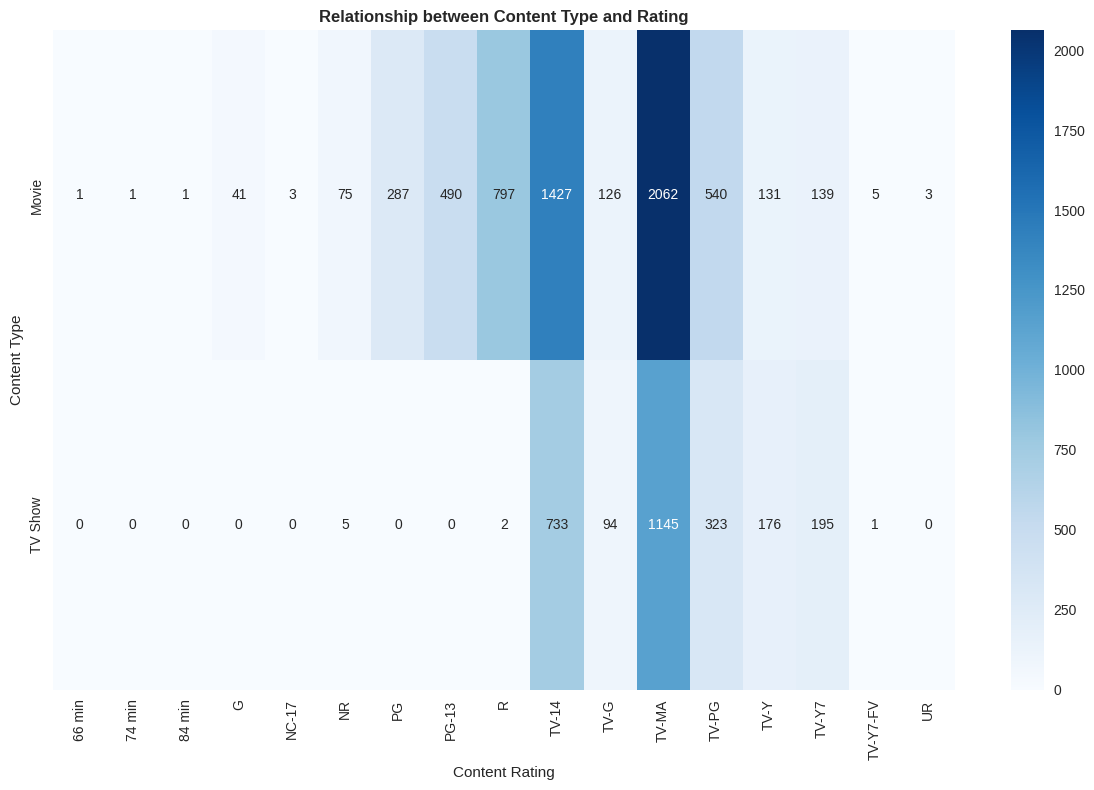

In [26]:

# Relationships between two categorical variables (e.g., stacked bar charts or heatmaps)
if 'type' in categorical_cols and 'rating' in categorical_cols:
    plt.figure(figsize=(12, 8))
    sns.heatmap(pd.crosstab(df['type'], df['rating']), annot=True, fmt='d', cmap='Blues')
    plt.title('Relationship between Content Type and Rating', fontweight='bold')
    plt.xlabel('Content Rating')
    plt.ylabel('Content Type')
    plt.tight_layout()
    plt.show()


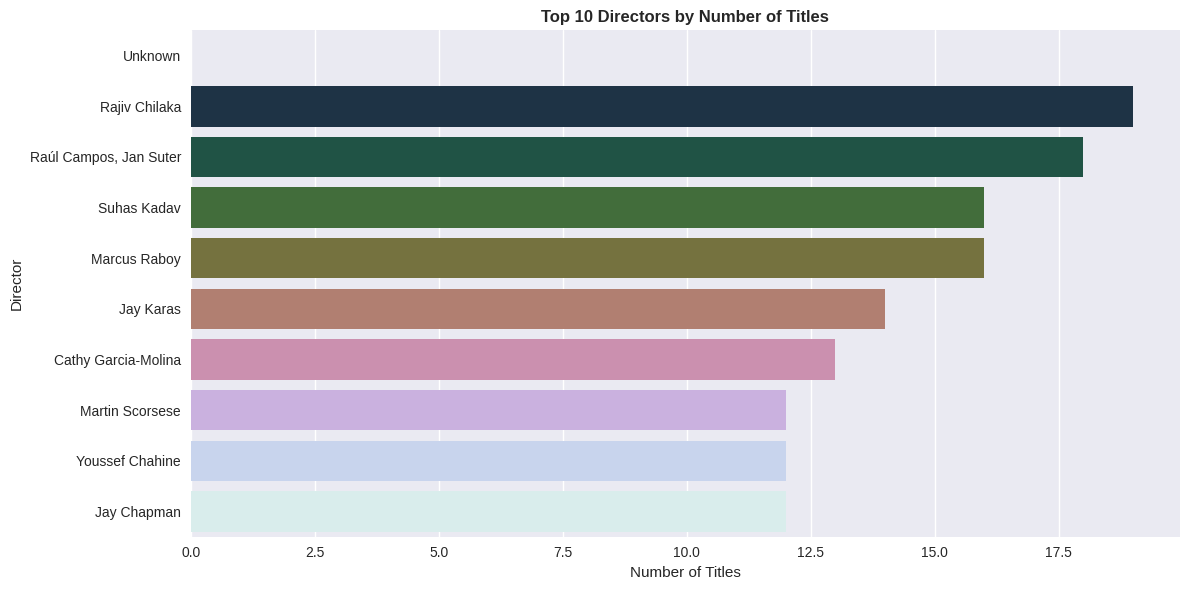

In [28]:
# Analyzing relationships involving 'director' or 'cast' might require different approaches
# e.g., looking at most frequent directors/actors per content type, but this is more complex
# and might be beyond standard multivariate plots.
# Example: Top directors by number of titles
if 'director' in categorical_cols:
     # Need to handle multiple directors per entry if applicable, but assuming one for now
    top_directors = df['director'].value_counts().nlargest(10).index
    df_top_directors = df[df['director'].isin(top_directors) & (df['director'] != 'Unknown')]

    if not df_top_directors.empty:
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df_top_directors, y='director', order=top_directors, palette='cubehelix')
        plt.title('Top 10 Directors by Number of Titles', fontweight='bold')
        plt.xlabel('Number of Titles')
        plt.ylabel('Director')
        plt.tight_layout()
        plt.show()
    else:
         print("Not enough data to plot top directors.")

# Example: Top actors by number of titles
if 'cast' in categorical_cols:
    # Need to split the cast string and count each actor
    # This is a simplified approach, assuming each actor is separated by ', '
    actors_list = df['cast'].dropna().str.split(', ').explode()
    top_actors = actors_list.value_counts().nlargest(10).index

    actors_data = actors_list[actors_list.isin(top_actors)]



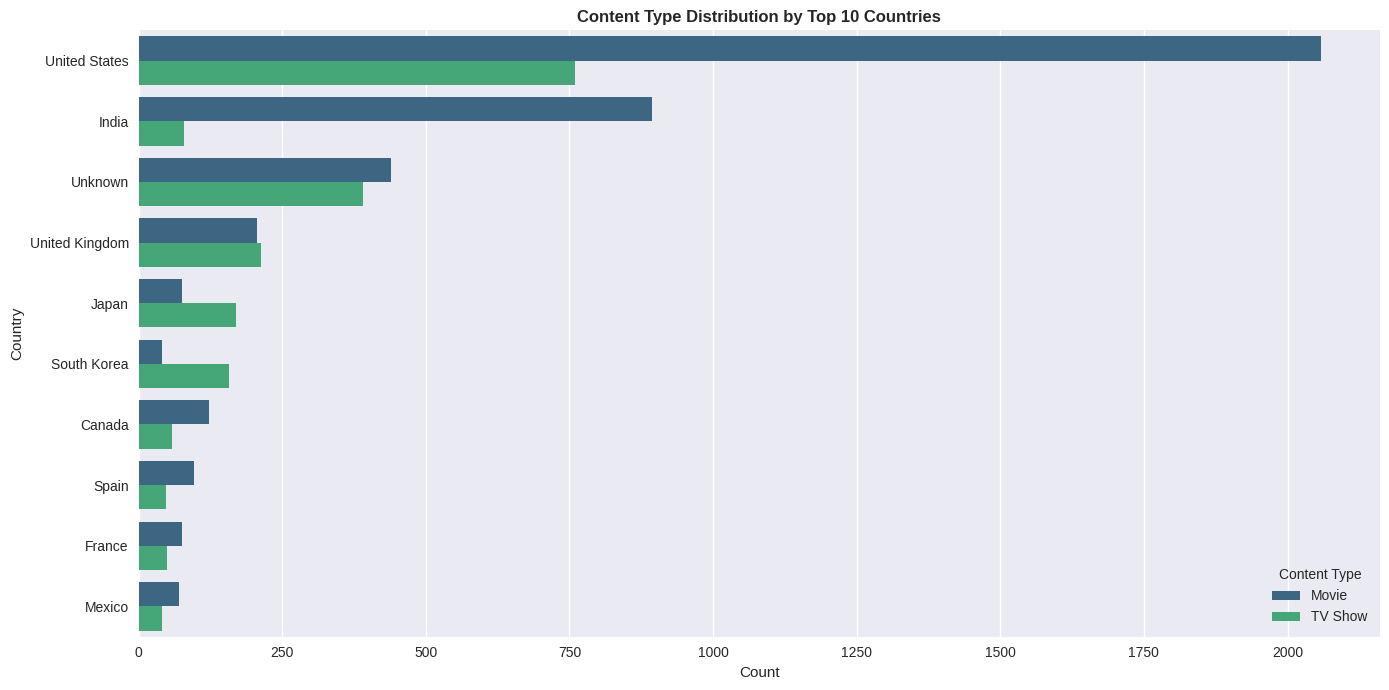

In [29]:
# Analyzing relationships involving 'country' (top N countries)
if 'country' in categorical_cols and 'type' in categorical_cols:
    # Get top N countries (e.g., top 10)
    top_countries = df['country'].value_counts().nlargest(10).index
    df_top_countries = df[df['country'].isin(top_countries)]

    if not df_top_countries.empty:
        plt.figure(figsize=(14, 7))
        sns.countplot(data=df_top_countries, y='country', hue='type', order=top_countries, palette='viridis')
        plt.title('Content Type Distribution by Top 10 Countries', fontweight='bold')
        plt.xlabel('Count')
        plt.ylabel('Country')
        plt.legend(title='Content Type')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data to plot content type distribution by top countries.")

## 6. Outlier Detection & Analysis


--- Outlier Detection & Analysis ---

Analyzing outliers in Movie Durations:


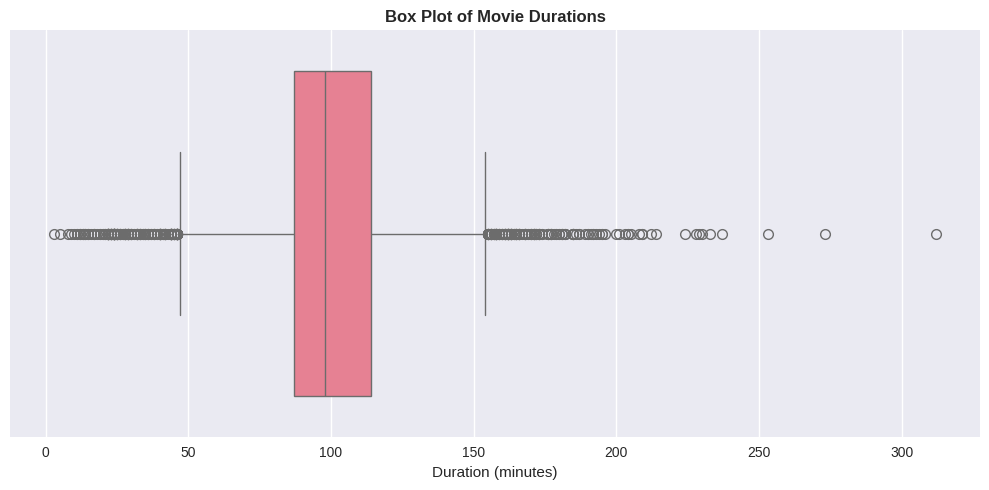

Number of outlier movie durations (IQR method): 450
Examples of outlier movie durations:
22    161.0
24    166.0
45     23.0
71     13.0
73    182.0
Name: duration_int, dtype: float64


In [36]:

print("\n--- Outlier Detection & Analysis ---")

# Select numerical columns for outlier analysis
numeric_cols_for_outliers = ['release_year'] # 'duration_int' might also be relevant but needs careful interpretation (minutes vs seasons)

if 'duration_int' in numeric_cols:
     # Consider duration for movies only, as TV show seasons might vary widely
     movie_durations = df[df['type'] == 'Movie']['duration_int'].dropna()
     if not movie_durations.empty:
        print("\nAnalyzing outliers in Movie Durations:")
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=movie_durations)
        plt.title('Box Plot of Movie Durations', fontweight='bold')
        plt.xlabel('Duration (minutes)')
        plt.tight_layout()
        plt.show()

        # Calculate IQR and bounds for movie durations
        Q1 = movie_durations.quantile(0.25)
        Q3 = movie_durations.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_iqr = movie_durations[(movie_durations < lower_bound) | (movie_durations > upper_bound)]
        print(f"Number of outlier movie durations (IQR method): {len(outliers_iqr)}")
        if len(outliers_iqr) > 0:
            print("Examples of outlier movie durations:")
            print(outliers_iqr.head())






Analyzing 'release_year' distribution (looking for potential anomalies):


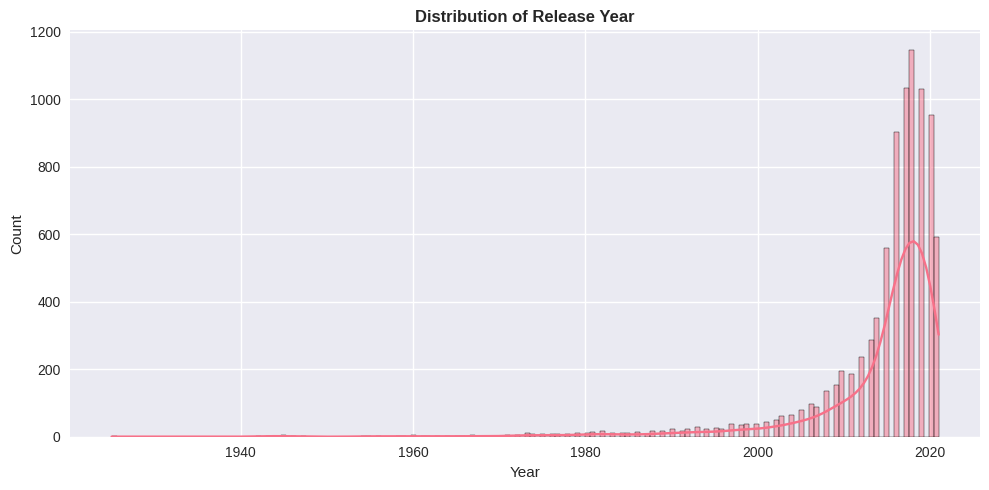

Number of 'release_year' values with Z-score > 3: 217
Examples of outlier 'release_year' values (based on Z-score):
41     1975
42     1978
43     1983
44     1987
131    1982
Name: release_year, dtype: int32

Analysis of rare categories (potential 'outliers' in categorical data):

Rare categories in 'director':
director
Dan Villegas                              4
Maroun Baghdadi                           4
Antoine Fuqua                             4
Masahiko Murata                           4
Barry Avrich                              4
                                         ..
Milla Harrison-Hansley, Alicky Sussman    1
Drew Stone                                1
Benjamin Turner                           1
S. Shankar                                1
Peter Hewitt                              1
Name: count, Length: 4436, dtype: int64

Rare categories in 'cast':
cast
Tom Segura                                                                                                              

In [37]:
# Outlier detection for 'release_year' (less likely to have outliers in the traditional sense,
# but can show historical anomalies)
if 'release_year' in datetime_cols:
    release_years = df['release_year'].dt.year.dropna()
    if not release_years.empty:
        print("\nAnalyzing 'release_year' distribution (looking for potential anomalies):")
        plt.figure(figsize=(10, 5))
        sns.histplot(release_years, kde=True)
        plt.title('Distribution of Release Year', fontweight='bold')
        plt.xlabel('Year')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

        # Using Z-score for detecting values far from the mean (less suitable for year data usually)
        # or simply looking at years far outside the main distribution
        mean_year = release_years.mean()
        std_year = release_years.std()
        z_scores = np.abs((release_years - mean_year) / std_year)
        outliers_zscore = release_years[z_scores > 3] # Threshold of 3 standard deviations

        print(f"Number of 'release_year' values with Z-score > 3: {len(outliers_zscore)}")
        if len(outliers_zscore) > 0:
            print("Examples of outlier 'release_year' values (based on Z-score):")
            print(outliers_zscore.head())

# Note: Outliers in categorical or text data are different (e.g., rare categories, typos).
# These were partially addressed during data cleaning (e.g., 'Unknown').
# Further analysis might involve looking at categories with very low counts.
print("\nAnalysis of rare categories (potential 'outliers' in categorical data):")
for col in categorical_cols:
    if col not in ['show_id', 'title', 'description']: # Exclude identifiers/free text
        value_counts = df[col].value_counts(dropna=False)
        rare_categories = value_counts[value_counts < 5] # Example threshold: categories with less than 5 occurrences
        if not rare_categories.empty:
            print(f"\nRare categories in '{col}':")
            print(rare_categories)

## 7. Executive Summary & Recommendations

## Executive Summary: Netflix Dataset EDA

---

### Dataset Overview
- Initial dataset contained **8,807 entries** and **15 features**.
- After cleaning (handling missing values, converting data types, removing duplicates), the dataset still retains **8,807 entries** and **15 features**.

---

### Key Findings from Exploratory Data Analysis

####  Content Type Distribution
- **Movies** dominate the platform: 6,131 entries  
- **TV Shows**: 2,676 entries  

####  Release Year Trend
- Content spans from **1925 to 2021**.  
- **Peak year:** 2018 with **1,147 titles** added.

####  Content Duration Analysis
- **Movies:** Average duration ≈ **99.6 minutes**  
- **TV Shows:** Average ≈ **1.8 seasons**

####  Geographic Distribution
- **Top Country:** United States with **2,818 titles**  
- U.S. leads in both Movies and TV Shows.

####  Content Rating Distribution
- Most common rating: **TV-MA** (3,207 titles)

####  Top Creators
- Most featured director: **Rajiv Chilaka** with **19 titles**

---

## Recommendations

---

### 1.  Content Strategy
- Increase focus on **TV Show production/acquisition** to balance content types.  
- Tailor content strategy to **high-content countries** like the U.S. using geographic insights.

### 2.  Data Enrichment
- Investigate and enrich **missing or unknown values** in `director`, `cast`, and `country`.
- Fill or infer **missing `date_added`** where possible.

### 3.  Outlier Management
- Analyze **extreme movie durations** to identify and correct possible data errors.

### 4. Feature Engineering
- Parse and analyze **`listed_in` (genres)** for genre trends and preferences.
- Extract individuals from `cast` and `director` fields for **popularity and frequency analysis**.
- Leverage `description` text for **natural language features**.

### 5.  Genre & Tag Deep Dive
- Conduct deeper analysis into **genre popularity, trends**, and **underrepresented content** based on the `listed_in` column.

---

By addressing these issues and insights, Netflix can make more informed decisions on content production, acquisition, and market targeting.


